In [1]:
pip install ktrain

Note: you may need to restart the kernel to use updated packages.


In [12]:
pip install torchvision

Note: you may need to restart the kernel to use updated packages.


# Imports

In [13]:
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import numpy as np
from matplotlib import pyplot as plt
import re
import string
import torch
import torchvision
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer
from nltk import download
download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Defining Tweet Class

In [3]:
class Tweet:
    def __init__(self):
        self.uid = None
        self.content = ''
        self.sentiment = ''

# Definining Methods for Data Loading and Cleaning

In [4]:
def cleanTweet(tweet):
#     print(tweet.content,"\n")
#     tweet.content = re.sub(r'@ [0-9a-zA-Z]+', '', tweet.content) # remove @ mentions
    tweet.content = re.sub(r'\_', '', tweet.content) # remove underscores
    tweet.content = re.sub(r'…', '', tweet.content) # remove elipses/dots
    tweet.content = re.sub(r'\.', '', tweet.content) # remove elipses/dots
    tweet.content = re.sub(r'^RT[\s]+', '', tweet.content) # remove RT
    tweet.content = re.sub("[#@©àâ€¦¥°¤ð¹ÿœ¾¨‡†§‹²¿¸ˆ]", '', tweet.content) # remove weird symbols
    tweet.content = tweet.content.split("http")[0].split('https')[0] # remove http/https
    tweet.content = ''.join([i for i in tweet.content if not i.isdigit()]) # remove digits
    tweet.content = ''.join([word for word in tweet.content if word not in string.punctuation]) # remove punctuations
    tweet.content = TweetTokenizer(preserve_case=False, strip_handles=True,reduce_len=True).tokenize(tweet.content)
    tweet.content = ' '.join([i for i in tweet.content]) # convert to string
#     print(tweet.content)
#     print("============================================================================")
    return tweet

def load_stop_words():
    stopwords_english = stopwords.words('english')
    stopwords_hinglish = []
    with open('data/hinglish_stopwords.txt','r') as fp:
        while True:
            line = fp.readline()
            if not line:
                break
            stopwords_hinglish.append(line.strip())
    return stopwords_english, stopwords_hinglish

def readFile(filename, test_data=False):
    stemmer_english = PorterStemmer()
    stopwords_english, stopwords_hinglish = load_stop_words()
    all_tweets = []
    with open(filename, 'r', encoding="utf8") as fp:
        tweet = Tweet()
        last_one = False
        while True:
            line = fp.readline()
            if not line:
                last_one = True
            if len(line.split()) > 1 or last_one==True:
                if last_one==True or line.split()[0] == 'meta':
                    if len(tweet.content) > 0 or last_one==True:
                        all_tweets.append(cleanTweet(tweet))
                        if last_one==True:
                            break
                        tweet = Tweet()
                    tweet.uid = line.split()[1]
                    tweet.sentiment = line.split()[2] if test_data==False else None
                else:
                    if line.split()[1] == "Eng":
                        if line.split()[0] not in stopwords_english:
#                             line.split()[0] = autoCorrect(line.split()[0])
                            tweet.content += stemmer_english.stem(line.split()[0]) + " "
                    elif line.split()[1] == "Hin":
                        if line.split()[0] not in stopwords_hinglish:
                            tweet.content += line.split()[0] + " "
                    else:
                        tweet.content += line.split()[0] + " "
        return all_tweets

# Defining Method for Showing Results

In [5]:
def plot_confusion_matrix(cm,title='Confusion Matrix',cmap=plt.cm.Greens):
    import itertools
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    classes = ['neutral','positive','negative']
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' 
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
def show_results(y_test, y_pred):
    print("F1 Score: ", f1_score(y_test, y_pred, average="weighted"))
    print()
    cnf_matrix = confusion_matrix(y_test, y_pred, labels=[0,1,2])
    plot_confusion_matrix(cnf_matrix)

# ===================================================

# Mission Control - Training

### Data Loading

In [6]:
# all_tweets = readFile(r'data\train\train_14k_split_conll.txt')
# all_tweets.extend(readFile(r'data\train\dev_3k_split_conll.txt'))
all_tweets = (readFile(r'data/train/train_conll.txt'))
# all_tweets = (readFile(r'data\train\trial_conll.txt'))

### ktrain Stuff

In [7]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"]="0";

In [8]:
import tensorflow.keras
import tensorflow.keras.utils

In [9]:
import ktrain
from ktrain import text

In [10]:
x_train = [i.content for i in all_tweets]
y_train = [i.sentiment for i in all_tweets]

In [14]:
t = text.Transformer('vicgalle/xlm-roberta-large-xnli-anli')
trn = t.preprocess_train(x_train, y_train)
model = t.get_classifier()
learner = ktrain.get_learner(model, train_data=trn, batch_size=6)

preprocessing train...
language: id
train sequence lengths:
	mean : 13
	95percentile : 20
	99percentile : 24


Is Multi-Label? False


404 Client Error: Not Found for url: https://huggingface.co/vicgalle/xlm-roberta-large-xnli-anli/resolve/main/tf_model.h5
C:\Users\hp\anaconda3\lib\site-packages\ktrain\text\preprocessor.py:1070: UserWarning: Could not find Tensorflow version of model.  Attempting to download/load PyTorch version as TensorFlow model using from_pt=True. You will need PyTorch installed for this.
  warnings.warn('Could not find Tensorflow version of model.  Attempting to download/load PyTorch version as TensorFlow model using from_pt=True. ' +\


In [25]:
learner.fit_onecycle(2e-7, 1)



begin training using onecycle policy with max lr of 2e-07...
2522/2522 [==============================] - 1706s 676ms/step - loss: 0.6580 - accuracy: 0.7282


# ===================================================

# Mission Control - Prediction

### Loading Prediction Data

In [26]:
actual_labels_dict = dict()
with open(r'data/test/test_labels_hinglish.txt','r') as fp:
    line = fp.readline()
    while True:
        line = fp.readline()
        if not line:
            break
        actual_labels_dict[line.strip().split(',')[0]] = line.strip().split(',')[1]
all_test_tweets = readFile(r'data/test/Hindi_test_unalbelled_conll_updated.txt',test_data=True)
for i in all_test_tweets:
    i.sentiment = actual_labels_dict[i.uid]

### Getting the Predictions

In [27]:
predictor = ktrain.get_predictor(learner.model, preproc=t)
predictions = []
for i in all_test_tweets:
    predictions.append(predictor.predict(i.content))

### The Results

F1 Score:  0.7068083442864346



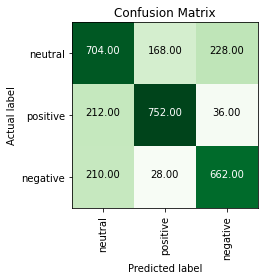

In [28]:
actual_num = []
for i in all_test_tweets:
    if i.sentiment == "neutral":
        actual_num.append(0)
    elif i.sentiment == "positive":
        actual_num.append(1)
    elif i.sentiment == "negative":
        actual_num.append(2)
predictions_num = []
for i in predictions:
    if i == "neutral":
        predictions_num.append(0)
    elif i == "positive":
        predictions_num.append(1)
    elif i == "negative":
        predictions_num.append(2)

show_results(actual_num, predictions_num)

# Analysing Incorrect Results

In [29]:
for i in range(len(actual_num)):
    if (actual_num[i]!=predictions_num[i]):
        print("Actual:",all_test_tweets[i].sentiment)
        print("Predicted:",predictions[i][0][0][9:])
        print(all_test_tweets[i].content)
        print("=====================================================================")

Actual: neutral
Predicted: 
alloo pyaz tomat allah pak naam nazar aa pr aankhon samne allah pak nazar
Actual: neutral
Predicted: 
bomanirani hny ki announc hogyi humka gola rehna nikal jaounga gola
Actual: negative
Predicted: 
sadifabi shahidmasooddr tm dikha rhy asli auqaat wese btao tou ye propaganda kyu krta shahid masood
Actual: positive
Predicted: 
dheeraj nirahua msunilbishnoi wah shandaar jabab
Actual: positive
Predicted: 
baijnathmourya mssirsa aapkamanojs arvindkejriwal haan mai free wifi dunga free water sasti bijli doo
Actual: negative
Predicted: 
asifnkhan saumen banerj e jhasanjay time circumst ke change bada bewakuf
Actual: neutral
Predicted: 
iawoolford kuchh samajh shukla ji thoda respect dena sikh tumhe south indian languag
Actual: negative
Predicted: 
sir arvindkejriwal aap drama kr km
Actual: negative
Predicted: 
majorpoonia mahilaye labh uthayengi vote bjp dengi kyon sal kejariwsl ji
Actual: neutral
Predicted: 
qasimalirazaali ye bolne walo mar daba sakhte dabane ko

# ===================================================

### Creating Submission File

In [30]:
import zipfile
import os

with open('answer.txt',"w") as fp:
    fp.write("Uid,Sentiment\n")
    for i in range(len(predictions_num)):
        if predictions_num[i]==0:
            if i==(len(predictions_num)-1):
                fp.write(all_test_tweets[i].uid+",neutral")
            else:
                fp.write(all_test_tweets[i].uid+",neutral\n")
        elif predictions_num[i]==1:
            if i==(len(predictions_num)-1):
                fp.write(all_test_tweets[i].uid+",positive")
            else:
                fp.write(all_test_tweets[i].uid+",positive\n")                
        elif predictions_num[i]==2:
            if i==(len(predictions_num)-1):
                fp.write(all_test_tweets[i].uid+",negative")
            else:
                fp.write(all_test_tweets[i].uid+",negative\n")

class ZipUtilities:
    def toZip(self, file, filename):
        zip_file = zipfile.ZipFile(filename, 'w')
        if os.path.isfile(file):
            zip_file.write(file)
        else:
            self.addFolderToZip(zip_file, file)
        zip_file.close()

    def addFolderToZip(self, zip_file, folder): 
        for file in os.listdir(folder):
            full_path = os.path.join(folder, file)
            if os.path.isfile(full_path):
                print( 'File added: ' + str(full_path))
                zip_file.write(full_path)
            elif os.path.isdir(full_path):
                print( 'Entering folder: ' + str(full_path))
                self.addFolderToZip(zip_file, full_path)

utilities = ZipUtilities()
filename = 'answer.zip'
directory = 'answer.txt'
utilities.toZip(directory, filename)